# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
import sys, os

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("src"))))

from src.Mydataloader import LoadDataset
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining
from src.Earlystopper import EarlyStopper
from src.LogViewer import LogViewer

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Dataset parameters"""
BATCH = 128
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0

"""optimizer parameters"""
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"
OPTIMIZER = "SGD"
# OPTIMIZER = "SGD_nasterov"
# OPTIMIZER = "AdamW"
# OPTIMIZER = "AdamW_amsgrad"
# OPTIMIZER = "NAdam"

"""Learning rate scheduler parameters"""
NUM_EPOCHS = 164

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 200

file_name = f"MyResNet32_{BATCH}_{OPTIMIZER}"

In [3]:
file_name

'MyResNet32_128_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
tmp = LoadDataset(root="../../data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [5]:
train_dataloader, valid_dataloader, test_dataloader = tmp.get_dataloader(
    batch_size=BATCH, shuffle=SHUFFLE, num_workers=NUMOFWORKERS, pin_memory=PIN_MEMORY
)


train.transforms = Compose(
      Compose(
        ToImage()
        ToDtype(scale=True)
  )
      Normalize(mean=[0.49139968, 0.48215827, 0.44653124], std=[1, 1, 1], inplace=True)
      AutoAugment(interpolation=InterpolationMode.NEAREST, policy=AutoAugmentPolicy.CIFAR10)
      RandomCrop(size=(32, 32), padding=[4, 4, 4, 4], pad_if_needed=False, fill=0, padding_mode=constant)
      RandomHorizontalFlip(p=0.5)
) 128
test.transforms = Compose(
      ToImage()
      ToDtype(scale=True)
) 128


# Define ResNet

## Model Confirm

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = MyResNet_CIFAR(num_classes=COUNT_OF_CLASSES, num_layer_factor=5).to(device)

# Define Training

## (1) Define Criterion

In [8]:
criterion = nn.CrossEntropyLoss()

## (2) Define Optimazer

In [9]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )
elif OPTIMIZER == "SGD_nasterov":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4, nesterov=True
    )
elif OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "AdamW_amsgrad":
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-4, amsgrad=True)
elif OPTIMIZER == "NAdam":
    optimizer = torch.optim.NAdam(model.parameters(), weight_decay=1e-4)

## (3) Define Early Stopping

In [10]:
earlystopper = EarlyStopper(patience=EARLYSTOPPINGPATIENCE, model=model, file_name=file_name)

## (4) Define Learning Rate schedualer

In [11]:
# scheduler = ExponentialLR(optimizer, gamma=0.95)
scheduler = MultiStepLR(optimizer, milestones=[82, 123], gamma=0.1)
"""
=======================================================
if batch = 256
=======================================================
non-split [single epoch = 196 iter] : milestones = [164, 246]
- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1
- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01
- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]
- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1
- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01
- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
if batch = 128
=======================================================
non-split [signle epoch = 391 iter]: milestones = [82, 123]
- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1
- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01
- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
split to 45k/5k [signle epoch = 352 iter]: milestones = [91, 137]
- 1~91 epochs == 1 ~ 32k iter >> lr = 0.1
- 92~137 epochs == 32k ~ 48k iter >> lr = 0.01
- 138~(183) epochs == 48k ~ 64k iter >> lr = 0.001
=======================================================
"""

'\n=======================================================\nif batch = 256\n=======================================================\nnon-split [single epoch = 196 iter] : milestones = [164, 246]\n- 1 ~ 164 epochs == 1 ~ 32k iter >> lr = 0.1\n- 165~246 epochs == 32k ~ 48k iter >> lr = 0.01\n- 247~328(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nsplit to 45k/5k [single epoch = 176 iter]: milestones = [182, 273]\n- 1~182 epochs == 1 ~ 32k iter >> lr = 0.1\n- 182~273 epochs == 32k ~ 48k iter >> lr = 0.01\n- 273~364(?) epochs == 48k ~ 64k iter >> lr = 0.001\n=======================================================\nif batch = 128\n=======================================================\nnon-split [signle epoch = 391 iter]: milestones = [82, 123]\n- 1 ~ 82 epochs == 1 ~ 32k iter >> lr = 0.1\n- 83~123 epochs == 32k ~ 48k iter >> lr = 0.01\n- 124~(164) epochs == 48k ~ 64k iter >> lr = 0.001\n=================================================

## (5) Define AMP scaler

In [12]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [13]:
if os.path.exists(file_name + ".pth.tar"):
    # Read checkpoint as desired, e.g.,
    checkpoint = torch.load(
        file_name + ".pth.tar",
        map_location=lambda storage, loc: storage.cuda(device),
    )
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scaler.load_state_dict(checkpoint["scaler"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    earlystopper.load_state_dict(checkpoint["earlystopper"])
    logs = checkpoint["logs"]

    print("Suceessfully loaded the All setting and Log file.")
    print(file_name)
    print(f"Current epoch is {len(logs['train_loss'])}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []
    lr_log = []
    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
        "lr_log": lr_log,
    }
    print("File does not exist. Created a new log.")

Suceessfully loaded the All setting and Log file.
MyResNet32_128_SGD
Current epoch is 164
Current learning rate: 0.0010000000000000002


In [14]:
optimizer.param_groups[0]["lr"]

0.0010000000000000002

In [15]:
earlystopper.early_stop_counter

20

In [16]:
hnvnhngf

NameError: name 'hnvnhngf' is not defined

# [Training Loop]

In [ ]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    earlystopper=earlystopper,
    device=device,
    logs=logs,
    file_path=file_name,
)
pre_epochs = len(Training.logs["train_loss"])


for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    Training.Save()

    
    
    if earlystopper.check(eval_loss) == True:
        break

    print("-" * 50)

[Epoch 1/164] :


1 Train: 100%|███████| 391/391 [00:07<00:00, 48.90it/s]

Train Loss: 2.2826 | Train Acc: 16.93%


Test  Loss: 1.9642 | Test Acc: 22.79%
updated best eval loss : 1.9641635659374768
--------------------------------------------------
[Epoch 2/164] :


2 Train: 100%|███████| 391/391 [00:06<00:00, 62.15it/s]


Train Loss: 1.9653 | Train Acc: 26.25%
Test  Loss: 1.9019 | Test Acc: 28.67%
updated best eval loss : 1.9019395203530034
--------------------------------------------------
[Epoch 3/164] :


3 Train: 100%|███████| 391/391 [00:06<00:00, 62.10it/s]


Train Loss: 1.7514 | Train Acc: 35.51%
Test  Loss: 1.4698 | Test Acc: 46.36%
updated best eval loss : 1.4698347275770163
--------------------------------------------------
[Epoch 4/164] :


4 Train: 100%|███████| 391/391 [00:06<00:00, 62.61it/s]


Train Loss: 1.4882 | Train Acc: 46.21%
Test  Loss: 1.1483 | Test Acc: 59.01%
updated best eval loss : 1.1483210038535203
--------------------------------------------------
[Epoch 5/164] :


5 Train: 100%|███████| 391/391 [00:06<00:00, 59.79it/s]


Train Loss: 1.2936 | Train Acc: 53.89%
Test  Loss: 1.1093 | Test Acc: 60.72%
updated best eval loss : 1.1093122747879993
--------------------------------------------------
[Epoch 6/164] :


6 Train: 100%|███████| 391/391 [00:06<00:00, 60.68it/s]


Train Loss: 1.1643 | Train Acc: 58.87%
Test  Loss: 0.9847 | Test Acc: 65.48%
updated best eval loss : 0.9847450648682027
--------------------------------------------------
[Epoch 7/164] :


7 Train: 100%|███████| 391/391 [00:05<00:00, 65.50it/s]


Train Loss: 1.0845 | Train Acc: 61.66%
Test  Loss: 0.8402 | Test Acc: 71.25%
updated best eval loss : 0.840236899973471
--------------------------------------------------
[Epoch 8/164] :


8 Train: 100%|███████| 391/391 [00:06<00:00, 63.68it/s]


Train Loss: 1.0271 | Train Acc: 64.04%
Test  Loss: 0.8961 | Test Acc: 70.92%
--------------------------------------------------
[Epoch 9/164] :


9 Train: 100%|███████| 391/391 [00:06<00:00, 61.89it/s]


Train Loss: 0.9825 | Train Acc: 65.48%
Test  Loss: 0.7799 | Test Acc: 72.78%
updated best eval loss : 0.7798726453056818
--------------------------------------------------
[Epoch 10/164] :


10 Train: 100%|██████| 391/391 [00:06<00:00, 64.89it/s]


Train Loss: 0.9492 | Train Acc: 66.85%
Test  Loss: 0.8685 | Test Acc: 70.68%
--------------------------------------------------
[Epoch 11/164] :


11 Train: 100%|██████| 391/391 [00:08<00:00, 47.65it/s]


Train Loss: 0.9233 | Train Acc: 67.73%
Test  Loss: 0.7309 | Test Acc: 75.45%
updated best eval loss : 0.7309356407274173
--------------------------------------------------
[Epoch 12/164] :


12 Train: 100%|██████| 391/391 [00:08<00:00, 44.51it/s]


Train Loss: 0.8965 | Train Acc: 68.72%
Test  Loss: 0.6639 | Test Acc: 77.66%
updated best eval loss : 0.6638936536221565
--------------------------------------------------
[Epoch 13/164] :


13 Train: 100%|██████| 391/391 [00:08<00:00, 44.54it/s]


Train Loss: 0.8677 | Train Acc: 69.76%
Test  Loss: 0.6075 | Test Acc: 79.44%
updated best eval loss : 0.6074503494214408
--------------------------------------------------
[Epoch 14/164] :


14 Train: 100%|██████| 391/391 [00:08<00:00, 43.69it/s]


Train Loss: 0.8508 | Train Acc: 70.28%
Test  Loss: 0.6334 | Test Acc: 78.03%
--------------------------------------------------
[Epoch 15/164] :


15 Train: 100%|██████| 391/391 [00:08<00:00, 43.90it/s]


Train Loss: 0.8305 | Train Acc: 70.83%
Test  Loss: 0.6206 | Test Acc: 78.52%
--------------------------------------------------
[Epoch 16/164] :


16 Train: 100%|██████| 391/391 [00:08<00:00, 44.12it/s]


Train Loss: 0.8126 | Train Acc: 71.53%
Test  Loss: 0.7391 | Test Acc: 74.76%
--------------------------------------------------
[Epoch 17/164] :


17 Train: 100%|██████| 391/391 [00:08<00:00, 45.20it/s]


Train Loss: 0.8005 | Train Acc: 71.86%
Test  Loss: 0.5664 | Test Acc: 81.20%
updated best eval loss : 0.5663715838631497
--------------------------------------------------
[Epoch 18/164] :


18 Train: 100%|██████| 391/391 [00:08<00:00, 44.33it/s]


Train Loss: 0.7911 | Train Acc: 72.59%
Test  Loss: 0.5268 | Test Acc: 81.95%
updated best eval loss : 0.526774449816233
--------------------------------------------------
[Epoch 19/164] :


19 Train: 100%|██████| 391/391 [00:09<00:00, 42.51it/s]


Train Loss: 0.7751 | Train Acc: 72.98%
Test  Loss: 0.6561 | Test Acc: 77.99%
--------------------------------------------------
[Epoch 20/164] :


20 Train: 100%|██████| 391/391 [00:08<00:00, 43.86it/s]


Train Loss: 0.7673 | Train Acc: 73.34%
Test  Loss: 0.5618 | Test Acc: 80.91%
--------------------------------------------------
[Epoch 21/164] :


21 Train: 100%|██████| 391/391 [00:08<00:00, 44.84it/s]


Train Loss: 0.7596 | Train Acc: 73.45%
Test  Loss: 0.6961 | Test Acc: 76.69%
--------------------------------------------------
[Epoch 22/164] :


22 Train: 100%|██████| 391/391 [00:08<00:00, 43.46it/s]


Train Loss: 0.7487 | Train Acc: 73.87%
Test  Loss: 0.6088 | Test Acc: 79.47%
--------------------------------------------------
[Epoch 23/164] :


23 Train: 100%|██████| 391/391 [00:08<00:00, 45.06it/s]


Train Loss: 0.7377 | Train Acc: 74.28%
Test  Loss: 0.6323 | Test Acc: 79.98%
--------------------------------------------------
[Epoch 24/164] :


24 Train: 100%|██████| 391/391 [00:08<00:00, 44.26it/s]


Train Loss: 0.7355 | Train Acc: 74.15%
Test  Loss: 0.6152 | Test Acc: 79.31%
--------------------------------------------------
[Epoch 25/164] :


25 Train: 100%|██████| 391/391 [00:08<00:00, 44.50it/s]


Train Loss: 0.7245 | Train Acc: 74.64%
Test  Loss: 0.6310 | Test Acc: 78.80%
--------------------------------------------------
[Epoch 26/164] :


26 Train: 100%|██████| 391/391 [00:08<00:00, 44.41it/s]


Train Loss: 0.7188 | Train Acc: 74.79%
Test  Loss: 0.5372 | Test Acc: 81.56%
--------------------------------------------------
[Epoch 27/164] :


27 Train: 100%|██████| 391/391 [00:08<00:00, 44.11it/s]


Train Loss: 0.7153 | Train Acc: 75.15%
Test  Loss: 0.6560 | Test Acc: 78.15%
--------------------------------------------------
[Epoch 28/164] :


28 Train: 100%|██████| 391/391 [00:08<00:00, 44.07it/s]


Train Loss: 0.7146 | Train Acc: 75.26%
Test  Loss: 0.5985 | Test Acc: 79.48%
--------------------------------------------------
[Epoch 29/164] :


29 Train: 100%|██████| 391/391 [00:08<00:00, 44.32it/s]


Train Loss: 0.6970 | Train Acc: 75.47%
Test  Loss: 0.5452 | Test Acc: 81.15%
--------------------------------------------------
[Epoch 30/164] :


30 Train: 100%|██████| 391/391 [00:08<00:00, 45.96it/s]


Train Loss: 0.6953 | Train Acc: 75.47%
Test  Loss: 0.4721 | Test Acc: 83.55%
updated best eval loss : 0.4720591140698783
--------------------------------------------------
[Epoch 31/164] :


31 Train: 100%|██████| 391/391 [00:08<00:00, 44.50it/s]


Train Loss: 0.6889 | Train Acc: 75.94%
Test  Loss: 0.5372 | Test Acc: 81.74%
--------------------------------------------------
[Epoch 32/164] :


32 Train: 100%|██████| 391/391 [00:08<00:00, 44.16it/s]


Train Loss: 0.6828 | Train Acc: 76.11%
Test  Loss: 0.4877 | Test Acc: 83.04%
--------------------------------------------------
[Epoch 33/164] :


33 Train: 100%|██████| 391/391 [00:08<00:00, 44.74it/s]


Train Loss: 0.6837 | Train Acc: 76.12%
Test  Loss: 0.5433 | Test Acc: 81.86%
--------------------------------------------------
[Epoch 34/164] :


34 Train: 100%|██████| 391/391 [00:08<00:00, 44.84it/s]


Train Loss: 0.6747 | Train Acc: 76.46%
Test  Loss: 0.4835 | Test Acc: 83.34%
--------------------------------------------------
[Epoch 35/164] :


35 Train: 100%|██████| 391/391 [00:08<00:00, 44.25it/s]


Train Loss: 0.6723 | Train Acc: 76.49%
Test  Loss: 0.4852 | Test Acc: 83.23%
--------------------------------------------------
[Epoch 36/164] :


36 Train: 100%|██████| 391/391 [00:08<00:00, 45.32it/s]


Train Loss: 0.6673 | Train Acc: 76.79%
Test  Loss: 0.5138 | Test Acc: 82.35%
--------------------------------------------------
[Epoch 37/164] :


37 Train: 100%|██████| 391/391 [00:08<00:00, 43.69it/s]


Train Loss: 0.6662 | Train Acc: 76.72%
Test  Loss: 0.5414 | Test Acc: 81.78%
--------------------------------------------------
[Epoch 38/164] :


38 Train: 100%|██████| 391/391 [00:08<00:00, 44.33it/s]


Train Loss: 0.6573 | Train Acc: 77.03%
Test  Loss: 0.4540 | Test Acc: 84.62%
updated best eval loss : 0.45397754145573965
--------------------------------------------------
[Epoch 39/164] :


39 Train: 100%|██████| 391/391 [00:08<00:00, 44.53it/s]


Train Loss: 0.6648 | Train Acc: 76.93%
Test  Loss: 0.5304 | Test Acc: 82.54%
--------------------------------------------------
[Epoch 40/164] :


40 Train: 100%|██████| 391/391 [00:08<00:00, 45.03it/s]


Train Loss: 0.6471 | Train Acc: 77.44%
Test  Loss: 0.4600 | Test Acc: 84.43%
--------------------------------------------------
[Epoch 41/164] :


41 Train: 100%|██████| 391/391 [00:08<00:00, 44.98it/s]


Train Loss: 0.6498 | Train Acc: 77.38%
Test  Loss: 0.4705 | Test Acc: 84.19%
--------------------------------------------------
[Epoch 42/164] :


42 Train: 100%|██████| 391/391 [00:08<00:00, 45.01it/s]


Train Loss: 0.6452 | Train Acc: 77.54%
Test  Loss: 0.4849 | Test Acc: 83.75%
--------------------------------------------------
[Epoch 43/164] :


43 Train: 100%|██████| 391/391 [00:08<00:00, 44.38it/s]


Train Loss: 0.6407 | Train Acc: 77.69%
Test  Loss: 0.5736 | Test Acc: 80.92%
--------------------------------------------------
[Epoch 44/164] :


44 Train: 100%|██████| 391/391 [00:08<00:00, 44.24it/s]


Train Loss: 0.6371 | Train Acc: 77.83%
Test  Loss: 0.4915 | Test Acc: 83.54%
--------------------------------------------------
[Epoch 45/164] :


45 Train: 100%|██████| 391/391 [00:08<00:00, 44.51it/s]


Train Loss: 0.6343 | Train Acc: 78.01%
Test  Loss: 0.4646 | Test Acc: 83.87%
--------------------------------------------------
[Epoch 46/164] :


46 Train: 100%|██████| 391/391 [00:08<00:00, 43.68it/s]


Train Loss: 0.6380 | Train Acc: 77.86%
Test  Loss: 0.4828 | Test Acc: 83.22%
--------------------------------------------------
[Epoch 47/164] :


47 Train: 100%|██████| 391/391 [00:08<00:00, 43.65it/s]


Train Loss: 0.6361 | Train Acc: 77.89%
Test  Loss: 0.4436 | Test Acc: 85.00%
updated best eval loss : 0.4436088245880755
--------------------------------------------------
[Epoch 48/164] :


48 Train: 100%|██████| 391/391 [00:08<00:00, 44.52it/s]


Train Loss: 0.6258 | Train Acc: 78.09%
Test  Loss: 0.5080 | Test Acc: 83.02%
--------------------------------------------------
[Epoch 49/164] :


49 Train: 100%|██████| 391/391 [00:08<00:00, 45.12it/s]


Train Loss: 0.6255 | Train Acc: 78.15%
Test  Loss: 0.4258 | Test Acc: 85.56%
updated best eval loss : 0.42578835615628885
--------------------------------------------------
[Epoch 50/164] :


50 Train: 100%|██████| 391/391 [00:08<00:00, 45.07it/s]


Train Loss: 0.6328 | Train Acc: 77.90%
Test  Loss: 0.4546 | Test Acc: 84.67%
--------------------------------------------------
[Epoch 51/164] :


51 Train: 100%|██████| 391/391 [00:08<00:00, 45.44it/s]


Train Loss: 0.6257 | Train Acc: 78.37%
Test  Loss: 0.8336 | Test Acc: 74.16%
--------------------------------------------------
[Epoch 52/164] :


52 Train: 100%|██████| 391/391 [00:08<00:00, 44.74it/s]


Train Loss: 0.6160 | Train Acc: 78.62%
Test  Loss: 0.4323 | Test Acc: 85.06%
--------------------------------------------------
[Epoch 53/164] :


53 Train: 100%|██████| 391/391 [00:08<00:00, 44.46it/s]


Train Loss: 0.6099 | Train Acc: 78.65%
Test  Loss: 0.4368 | Test Acc: 85.06%
--------------------------------------------------
[Epoch 54/164] :


54 Train: 100%|██████| 391/391 [00:08<00:00, 44.94it/s]


Train Loss: 0.6121 | Train Acc: 78.60%
Test  Loss: 0.4045 | Test Acc: 86.58%
updated best eval loss : 0.4044940743265273
--------------------------------------------------
[Epoch 55/164] :


55 Train: 100%|██████| 391/391 [00:08<00:00, 44.96it/s]


Train Loss: 0.6046 | Train Acc: 78.81%
Test  Loss: 0.4460 | Test Acc: 85.16%
--------------------------------------------------
[Epoch 56/164] :


56 Train: 100%|██████| 391/391 [00:08<00:00, 45.65it/s]


Train Loss: 0.6114 | Train Acc: 78.72%
Test  Loss: 0.4708 | Test Acc: 84.18%
--------------------------------------------------
[Epoch 57/164] :


57 Train: 100%|██████| 391/391 [00:08<00:00, 44.02it/s]


Train Loss: 0.6047 | Train Acc: 78.92%
Test  Loss: 0.5199 | Test Acc: 82.52%
--------------------------------------------------
[Epoch 58/164] :


58 Train: 100%|██████| 391/391 [00:08<00:00, 44.27it/s]


Train Loss: 0.6060 | Train Acc: 78.82%
Test  Loss: 0.4452 | Test Acc: 85.35%
--------------------------------------------------
[Epoch 59/164] :


59 Train: 100%|██████| 391/391 [00:08<00:00, 44.14it/s]


Train Loss: 0.6002 | Train Acc: 79.02%
Test  Loss: 0.4702 | Test Acc: 83.83%
--------------------------------------------------
[Epoch 60/164] :


60 Train: 100%|██████| 391/391 [00:08<00:00, 44.80it/s]


Train Loss: 0.6053 | Train Acc: 78.86%
Test  Loss: 0.4801 | Test Acc: 84.08%
--------------------------------------------------
[Epoch 61/164] :


61 Train: 100%|██████| 391/391 [00:08<00:00, 45.19it/s]


Train Loss: 0.5938 | Train Acc: 79.47%
Test  Loss: 0.4306 | Test Acc: 85.43%
--------------------------------------------------
[Epoch 62/164] :


62 Train: 100%|██████| 391/391 [00:08<00:00, 46.16it/s]


Train Loss: 0.6030 | Train Acc: 78.92%
Test  Loss: 0.3829 | Test Acc: 86.19%
updated best eval loss : 0.38294219046453887
--------------------------------------------------
[Epoch 63/164] :


63 Train: 100%|██████| 391/391 [00:08<00:00, 44.45it/s]


Train Loss: 0.5991 | Train Acc: 79.21%
Test  Loss: 0.4103 | Test Acc: 85.64%
--------------------------------------------------
[Epoch 64/164] :


64 Train: 100%|██████| 391/391 [00:08<00:00, 43.92it/s]


Train Loss: 0.5979 | Train Acc: 79.18%
Test  Loss: 0.4128 | Test Acc: 86.07%
--------------------------------------------------
[Epoch 65/164] :


65 Train: 100%|██████| 391/391 [00:08<00:00, 44.43it/s]


Train Loss: 0.5898 | Train Acc: 79.41%
Test  Loss: 0.4523 | Test Acc: 84.81%
--------------------------------------------------
[Epoch 66/164] :


66 Train: 100%|██████| 391/391 [00:08<00:00, 44.38it/s]


Train Loss: 0.5925 | Train Acc: 79.24%
Test  Loss: 0.4351 | Test Acc: 85.00%
--------------------------------------------------
[Epoch 67/164] :


67 Train: 100%|██████| 391/391 [00:09<00:00, 43.44it/s]


Train Loss: 0.5893 | Train Acc: 79.32%
Test  Loss: 0.4346 | Test Acc: 84.74%
--------------------------------------------------
[Epoch 68/164] :


68 Train: 100%|██████| 391/391 [00:08<00:00, 44.35it/s]


Train Loss: 0.5875 | Train Acc: 79.38%
Test  Loss: 0.3759 | Test Acc: 87.10%
updated best eval loss : 0.3758655682772021
--------------------------------------------------
[Epoch 69/164] :


69 Train: 100%|██████| 391/391 [00:08<00:00, 44.89it/s]


Train Loss: 0.5937 | Train Acc: 79.39%
Test  Loss: 0.4214 | Test Acc: 85.54%
--------------------------------------------------
[Epoch 70/164] :


70 Train: 100%|██████| 391/391 [00:08<00:00, 44.50it/s]


Train Loss: 0.5833 | Train Acc: 79.61%
Test  Loss: 0.4256 | Test Acc: 85.67%
--------------------------------------------------
[Epoch 71/164] :


71 Train: 100%|██████| 391/391 [00:08<00:00, 45.14it/s]


Train Loss: 0.5881 | Train Acc: 79.46%
Test  Loss: 0.4451 | Test Acc: 85.15%
--------------------------------------------------
[Epoch 72/164] :


72 Train: 100%|██████| 391/391 [00:08<00:00, 44.93it/s]


Train Loss: 0.5759 | Train Acc: 79.73%
Test  Loss: 0.4167 | Test Acc: 85.73%
--------------------------------------------------
[Epoch 73/164] :


73 Train: 100%|██████| 391/391 [00:08<00:00, 44.85it/s]


Train Loss: 0.5838 | Train Acc: 79.63%
Test  Loss: 0.5593 | Test Acc: 81.54%
--------------------------------------------------
[Epoch 74/164] :


74 Train: 100%|██████| 391/391 [00:08<00:00, 44.03it/s]


Train Loss: 0.5841 | Train Acc: 79.50%
Test  Loss: 0.4218 | Test Acc: 86.13%
--------------------------------------------------
[Epoch 75/164] :


75 Train: 100%|██████| 391/391 [00:08<00:00, 45.38it/s]


Train Loss: 0.5824 | Train Acc: 79.46%
Test  Loss: 0.3592 | Test Acc: 87.66%
updated best eval loss : 0.35918782934357846
--------------------------------------------------
[Epoch 76/164] :


76 Train: 100%|██████| 391/391 [00:08<00:00, 44.66it/s]


Train Loss: 0.5757 | Train Acc: 80.04%
Test  Loss: 0.5193 | Test Acc: 83.19%
--------------------------------------------------
[Epoch 77/164] :


77 Train: 100%|██████| 391/391 [00:08<00:00, 44.17it/s]


Train Loss: 0.5776 | Train Acc: 79.97%
Test  Loss: 0.5562 | Test Acc: 81.79%
--------------------------------------------------
[Epoch 78/164] :


78 Train: 100%|██████| 391/391 [00:09<00:00, 43.26it/s]


Train Loss: 0.5784 | Train Acc: 79.73%
Test  Loss: 0.5174 | Test Acc: 82.79%
--------------------------------------------------
[Epoch 79/164] :


79 Train: 100%|██████| 391/391 [00:08<00:00, 43.86it/s]


Train Loss: 0.5728 | Train Acc: 80.01%
Test  Loss: 0.3945 | Test Acc: 86.32%
--------------------------------------------------
[Epoch 80/164] :


80 Train: 100%|██████| 391/391 [00:08<00:00, 44.37it/s]


Train Loss: 0.5743 | Train Acc: 79.92%
Test  Loss: 0.3607 | Test Acc: 87.34%
--------------------------------------------------
[Epoch 81/164] :


81 Train: 100%|██████| 391/391 [00:08<00:00, 44.08it/s]


Train Loss: 0.5690 | Train Acc: 80.13%
Test  Loss: 0.4873 | Test Acc: 84.47%
--------------------------------------------------
[Epoch 82/164] :


82 Train: 100%|██████| 391/391 [00:08<00:00, 45.43it/s]


Train Loss: 0.5718 | Train Acc: 80.06%
Test  Loss: 0.4064 | Test Acc: 86.35%
Learning Rate has changed : Now is 0.010000000000000002
--------------------------------------------------
[Epoch 83/164] :


83 Train: 100%|██████| 391/391 [00:08<00:00, 44.34it/s]


Train Loss: 0.4703 | Train Acc: 83.63%
Test  Loss: 0.2777 | Test Acc: 90.48%
updated best eval loss : 0.2776578104571451
--------------------------------------------------
[Epoch 84/164] :


84 Train: 100%|██████| 391/391 [00:08<00:00, 44.76it/s]


Train Loss: 0.4349 | Train Acc: 84.77%
Test  Loss: 0.2750 | Test Acc: 90.35%
updated best eval loss : 0.2750291826698599
--------------------------------------------------
[Epoch 85/164] :


85 Train: 100%|██████| 391/391 [00:08<00:00, 43.95it/s]


Train Loss: 0.4246 | Train Acc: 84.97%
Test  Loss: 0.2676 | Test Acc: 90.76%
updated best eval loss : 0.26763721866698204
--------------------------------------------------
[Epoch 86/164] :


86 Train: 100%|██████| 391/391 [00:08<00:00, 43.90it/s]


Train Loss: 0.4146 | Train Acc: 85.63%
Test  Loss: 0.2650 | Test Acc: 90.93%
updated best eval loss : 0.2649988450958759
--------------------------------------------------
[Epoch 87/164] :


87 Train: 100%|██████| 391/391 [00:08<00:00, 44.68it/s]


Train Loss: 0.4119 | Train Acc: 85.74%
Test  Loss: 0.2653 | Test Acc: 91.08%
--------------------------------------------------
[Epoch 88/164] :


88 Train: 100%|██████| 391/391 [00:08<00:00, 44.01it/s]


Train Loss: 0.4068 | Train Acc: 85.74%
Test  Loss: 0.2629 | Test Acc: 91.05%
updated best eval loss : 0.2629425181429597
--------------------------------------------------
[Epoch 89/164] :


89 Train: 100%|██████| 391/391 [00:08<00:00, 44.09it/s]


Train Loss: 0.3988 | Train Acc: 85.92%
Test  Loss: 0.2599 | Test Acc: 91.12%
updated best eval loss : 0.25994047814909416
--------------------------------------------------
[Epoch 90/164] :


90 Train: 100%|██████| 391/391 [00:09<00:00, 43.40it/s]


Train Loss: 0.3983 | Train Acc: 86.04%
Test  Loss: 0.2601 | Test Acc: 91.28%
--------------------------------------------------
[Epoch 91/164] :


91 Train: 100%|██████| 391/391 [00:08<00:00, 44.34it/s]


Train Loss: 0.3960 | Train Acc: 86.21%
Test  Loss: 0.2648 | Test Acc: 91.37%
--------------------------------------------------
[Epoch 92/164] :


92 Train: 100%|██████| 391/391 [00:08<00:00, 44.99it/s]


Train Loss: 0.3917 | Train Acc: 86.28%
Test  Loss: 0.2525 | Test Acc: 91.46%
updated best eval loss : 0.25249279903460153
--------------------------------------------------
[Epoch 93/164] :


93 Train: 100%|██████| 391/391 [00:08<00:00, 43.67it/s]


Train Loss: 0.3920 | Train Acc: 86.33%
Test  Loss: 0.2490 | Test Acc: 91.43%
updated best eval loss : 0.24896035416499723
--------------------------------------------------
[Epoch 94/164] :


94 Train: 100%|██████| 391/391 [00:08<00:00, 46.02it/s]


Train Loss: 0.3923 | Train Acc: 86.14%
Test  Loss: 0.2511 | Test Acc: 91.44%
--------------------------------------------------
[Epoch 95/164] :


95 Train: 100%|██████| 391/391 [00:08<00:00, 44.12it/s]


Train Loss: 0.3823 | Train Acc: 86.73%
Test  Loss: 0.2606 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 96/164] :


96 Train: 100%|██████| 391/391 [00:08<00:00, 44.13it/s]


Train Loss: 0.3881 | Train Acc: 86.41%
Test  Loss: 0.2577 | Test Acc: 91.30%
--------------------------------------------------
[Epoch 97/164] :


97 Train: 100%|██████| 391/391 [00:08<00:00, 43.89it/s]


Train Loss: 0.3762 | Train Acc: 86.80%
Test  Loss: 0.2610 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 98/164] :


98 Train: 100%|██████| 391/391 [00:08<00:00, 43.89it/s]


Train Loss: 0.3750 | Train Acc: 86.69%
Test  Loss: 0.2585 | Test Acc: 91.41%
--------------------------------------------------
[Epoch 99/164] :


99 Train: 100%|██████| 391/391 [00:08<00:00, 44.06it/s]


Train Loss: 0.3763 | Train Acc: 86.78%
Test  Loss: 0.2561 | Test Acc: 91.72%
--------------------------------------------------
[Epoch 100/164] :


100 Train: 100%|█████| 391/391 [00:08<00:00, 44.39it/s]


Train Loss: 0.3755 | Train Acc: 86.91%
Test  Loss: 0.2582 | Test Acc: 91.52%
--------------------------------------------------
[Epoch 101/164] :


101 Train: 100%|█████| 391/391 [00:08<00:00, 45.94it/s]


Train Loss: 0.3711 | Train Acc: 87.05%
Test  Loss: 0.2582 | Test Acc: 91.57%
--------------------------------------------------
[Epoch 102/164] :


102 Train: 100%|█████| 391/391 [00:08<00:00, 44.65it/s]


Train Loss: 0.3693 | Train Acc: 87.06%
Test  Loss: 0.2498 | Test Acc: 91.81%
--------------------------------------------------
[Epoch 103/164] :


103 Train: 100%|█████| 391/391 [00:08<00:00, 44.91it/s]


Train Loss: 0.3719 | Train Acc: 87.00%
Test  Loss: 0.2672 | Test Acc: 91.17%
--------------------------------------------------
[Epoch 104/164] :


104 Train: 100%|█████| 391/391 [00:08<00:00, 45.17it/s]


Train Loss: 0.3658 | Train Acc: 87.08%
Test  Loss: 0.2529 | Test Acc: 91.53%
--------------------------------------------------
[Epoch 105/164] :


105 Train: 100%|█████| 391/391 [00:08<00:00, 44.95it/s]


Train Loss: 0.3665 | Train Acc: 87.24%
Test  Loss: 0.2449 | Test Acc: 91.77%
updated best eval loss : 0.24491253306594077
--------------------------------------------------
[Epoch 106/164] :


106 Train: 100%|█████| 391/391 [00:08<00:00, 44.21it/s]


Train Loss: 0.3595 | Train Acc: 87.36%
Test  Loss: 0.2458 | Test Acc: 91.80%
--------------------------------------------------
[Epoch 107/164] :


107 Train: 100%|█████| 391/391 [00:08<00:00, 45.33it/s]


Train Loss: 0.3665 | Train Acc: 87.06%
Test  Loss: 0.2508 | Test Acc: 91.64%
--------------------------------------------------
[Epoch 108/164] :


108 Train: 100%|█████| 391/391 [00:08<00:00, 44.25it/s]


Train Loss: 0.3581 | Train Acc: 87.41%
Test  Loss: 0.2509 | Test Acc: 91.53%
--------------------------------------------------
[Epoch 109/164] :


109 Train: 100%|█████| 391/391 [00:08<00:00, 44.33it/s]


Train Loss: 0.3621 | Train Acc: 87.38%
Test  Loss: 0.2492 | Test Acc: 91.49%
--------------------------------------------------
[Epoch 110/164] :


110 Train: 100%|█████| 391/391 [00:08<00:00, 44.57it/s]


Train Loss: 0.3585 | Train Acc: 87.45%
Test  Loss: 0.2539 | Test Acc: 91.61%
--------------------------------------------------
[Epoch 111/164] :


111 Train: 100%|█████| 391/391 [00:08<00:00, 44.05it/s]


Train Loss: 0.3635 | Train Acc: 86.95%
Test  Loss: 0.2512 | Test Acc: 91.63%
--------------------------------------------------
[Epoch 112/164] :


112 Train: 100%|█████| 391/391 [00:08<00:00, 43.73it/s]


Train Loss: 0.3598 | Train Acc: 87.44%
Test  Loss: 0.2610 | Test Acc: 91.32%
--------------------------------------------------
[Epoch 113/164] :


113 Train: 100%|█████| 391/391 [00:08<00:00, 44.60it/s]


Train Loss: 0.3614 | Train Acc: 87.50%
Test  Loss: 0.2604 | Test Acc: 91.24%
--------------------------------------------------
[Epoch 114/164] :


114 Train: 100%|█████| 391/391 [00:08<00:00, 45.75it/s]


Train Loss: 0.3598 | Train Acc: 87.53%
Test  Loss: 0.2606 | Test Acc: 91.31%
--------------------------------------------------
[Epoch 115/164] :


115 Train: 100%|█████| 391/391 [00:08<00:00, 44.63it/s]


Train Loss: 0.3553 | Train Acc: 87.49%
Test  Loss: 0.2511 | Test Acc: 91.63%
--------------------------------------------------
[Epoch 116/164] :


116 Train: 100%|█████| 391/391 [00:08<00:00, 44.34it/s]


Train Loss: 0.3518 | Train Acc: 87.84%
Test  Loss: 0.2501 | Test Acc: 91.84%
--------------------------------------------------
[Epoch 117/164] :


117 Train: 100%|█████| 391/391 [00:09<00:00, 43.41it/s]


Train Loss: 0.3548 | Train Acc: 87.55%
Test  Loss: 0.2569 | Test Acc: 91.54%
--------------------------------------------------
[Epoch 118/164] :


118 Train: 100%|█████| 391/391 [00:10<00:00, 36.71it/s]


Train Loss: 0.3510 | Train Acc: 87.81%
Test  Loss: 0.2558 | Test Acc: 91.51%
--------------------------------------------------
[Epoch 119/164] :


119 Train: 100%|█████| 391/391 [00:13<00:00, 29.56it/s]


Train Loss: 0.3530 | Train Acc: 87.74%
Test  Loss: 0.2505 | Test Acc: 91.55%
--------------------------------------------------
[Epoch 120/164] :


120 Train: 100%|█████| 391/391 [00:12<00:00, 30.42it/s]


Train Loss: 0.3564 | Train Acc: 87.52%
Test  Loss: 0.2482 | Test Acc: 91.88%
--------------------------------------------------
[Epoch 121/164] :


121 Train: 100%|█████| 391/391 [00:12<00:00, 30.21it/s]


Train Loss: 0.3497 | Train Acc: 87.76%
Test  Loss: 0.2680 | Test Acc: 91.43%
--------------------------------------------------
[Epoch 122/164] :


122 Train: 100%|█████| 391/391 [00:12<00:00, 31.42it/s]


Train Loss: 0.3515 | Train Acc: 87.66%
Test  Loss: 0.2559 | Test Acc: 91.57%
--------------------------------------------------
[Epoch 123/164] :


123 Train: 100%|█████| 391/391 [00:12<00:00, 30.96it/s]


Train Loss: 0.3488 | Train Acc: 87.84%
Test  Loss: 0.2610 | Test Acc: 91.52%
Learning Rate has changed : Now is 0.0010000000000000002
--------------------------------------------------
[Epoch 124/164] :


124 Train: 100%|█████| 391/391 [00:13<00:00, 29.85it/s]


Train Loss: 0.3403 | Train Acc: 88.07%
Test  Loss: 0.2388 | Test Acc: 92.13%
updated best eval loss : 0.23878883419534827
--------------------------------------------------
[Epoch 125/164] :


125 Train: 100%|█████| 391/391 [00:12<00:00, 31.89it/s]


Train Loss: 0.3237 | Train Acc: 88.57%
Test  Loss: 0.2413 | Test Acc: 92.17%
--------------------------------------------------
[Epoch 126/164] :


126 Train: 100%|█████| 391/391 [00:13<00:00, 29.36it/s]


Train Loss: 0.3280 | Train Acc: 88.37%
Test  Loss: 0.2371 | Test Acc: 92.27%
updated best eval loss : 0.23710595184489142
--------------------------------------------------
[Epoch 127/164] :


127 Train: 100%|█████| 391/391 [00:12<00:00, 30.11it/s]


Train Loss: 0.3297 | Train Acc: 88.47%
Test  Loss: 0.2390 | Test Acc: 92.24%
--------------------------------------------------
[Epoch 128/164] :


128 Train: 100%|█████| 391/391 [00:13<00:00, 29.91it/s]


Train Loss: 0.3235 | Train Acc: 88.71%
Test  Loss: 0.2361 | Test Acc: 92.15%
updated best eval loss : 0.23608735038698475
--------------------------------------------------
[Epoch 129/164] :


129 Train: 100%|█████| 391/391 [00:12<00:00, 31.31it/s]


Train Loss: 0.3243 | Train Acc: 88.57%
Test  Loss: 0.2438 | Test Acc: 92.29%
--------------------------------------------------
[Epoch 130/164] :


130 Train: 100%|█████| 391/391 [00:12<00:00, 30.50it/s]


Train Loss: 0.3183 | Train Acc: 88.81%
Test  Loss: 0.2404 | Test Acc: 92.08%
--------------------------------------------------
[Epoch 131/164] :


131 Train: 100%|█████| 391/391 [00:13<00:00, 29.33it/s]


Train Loss: 0.3164 | Train Acc: 88.83%
Test  Loss: 0.2419 | Test Acc: 92.14%
--------------------------------------------------
[Epoch 132/164] :


132 Train: 100%|█████| 391/391 [00:13<00:00, 29.83it/s]


Train Loss: 0.3221 | Train Acc: 88.60%
Test  Loss: 0.2389 | Test Acc: 92.21%
--------------------------------------------------
[Epoch 133/164] :


133 Train: 100%|█████| 391/391 [00:13<00:00, 30.07it/s]


Train Loss: 0.3162 | Train Acc: 88.86%
Test  Loss: 0.2377 | Test Acc: 92.19%
--------------------------------------------------
[Epoch 134/164] :


134 Train: 100%|█████| 391/391 [00:13<00:00, 28.96it/s]


Train Loss: 0.3207 | Train Acc: 88.72%
Test  Loss: 0.2390 | Test Acc: 92.24%
--------------------------------------------------
[Epoch 135/164] :


135 Train: 100%|█████| 391/391 [00:13<00:00, 29.52it/s]


Train Loss: 0.3215 | Train Acc: 88.68%
Test  Loss: 0.2439 | Test Acc: 92.16%
--------------------------------------------------
[Epoch 136/164] :


136 Train: 100%|█████| 391/391 [00:12<00:00, 31.18it/s]


Train Loss: 0.3189 | Train Acc: 88.86%
Test  Loss: 0.2467 | Test Acc: 92.27%
--------------------------------------------------
[Epoch 137/164] :


137 Train: 100%|█████| 391/391 [00:12<00:00, 31.27it/s]


Train Loss: 0.3173 | Train Acc: 88.86%
Test  Loss: 0.2389 | Test Acc: 92.11%
--------------------------------------------------
[Epoch 138/164] :


138 Train: 100%|█████| 391/391 [00:12<00:00, 30.36it/s]


Train Loss: 0.3125 | Train Acc: 88.99%
Test  Loss: 0.2368 | Test Acc: 92.26%
--------------------------------------------------
[Epoch 139/164] :


139 Train: 100%|█████| 391/391 [00:12<00:00, 30.49it/s]


Train Loss: 0.3156 | Train Acc: 88.96%
Test  Loss: 0.2388 | Test Acc: 92.20%
--------------------------------------------------
[Epoch 140/164] :


140 Train: 100%|█████| 391/391 [00:12<00:00, 30.92it/s]


Train Loss: 0.3110 | Train Acc: 89.08%
Test  Loss: 0.2376 | Test Acc: 92.14%
--------------------------------------------------
[Epoch 141/164] :


141 Train: 100%|█████| 391/391 [00:12<00:00, 30.46it/s]


Train Loss: 0.3151 | Train Acc: 88.99%
Test  Loss: 0.2376 | Test Acc: 92.37%
--------------------------------------------------
[Epoch 142/164] :


142 Train: 100%|█████| 391/391 [00:13<00:00, 28.52it/s]


Train Loss: 0.3168 | Train Acc: 88.89%
Test  Loss: 0.2403 | Test Acc: 92.19%
--------------------------------------------------
[Epoch 143/164] :


143 Train: 100%|█████| 391/391 [00:12<00:00, 31.07it/s]


Train Loss: 0.3116 | Train Acc: 89.09%
Test  Loss: 0.2353 | Test Acc: 92.37%
updated best eval loss : 0.23532091939373861
--------------------------------------------------
[Epoch 144/164] :


144 Train: 100%|█████| 391/391 [00:12<00:00, 30.33it/s]


Train Loss: 0.3143 | Train Acc: 88.98%
Test  Loss: 0.2417 | Test Acc: 92.06%
--------------------------------------------------
[Epoch 145/164] :


145 Train: 100%|█████| 391/391 [00:12<00:00, 30.79it/s]


Train Loss: 0.3138 | Train Acc: 89.04%
Test  Loss: 0.2398 | Test Acc: 92.17%
--------------------------------------------------
[Epoch 146/164] :


146 Train: 100%|█████| 391/391 [00:13<00:00, 29.83it/s]


Train Loss: 0.3120 | Train Acc: 89.13%
Test  Loss: 0.2412 | Test Acc: 92.26%
--------------------------------------------------
[Epoch 147/164] :


147 Train: 100%|█████| 391/391 [00:12<00:00, 30.42it/s]


Train Loss: 0.3163 | Train Acc: 88.89%
Test  Loss: 0.2401 | Test Acc: 92.17%
--------------------------------------------------
[Epoch 148/164] :


148 Train: 100%|█████| 391/391 [00:13<00:00, 29.06it/s]


Train Loss: 0.3137 | Train Acc: 88.98%
Test  Loss: 0.2568 | Test Acc: 92.31%
--------------------------------------------------
[Epoch 149/164] :


149 Train: 100%|█████| 391/391 [00:12<00:00, 30.25it/s]


Train Loss: 0.3138 | Train Acc: 89.15%
Test  Loss: 0.2365 | Test Acc: 92.31%
--------------------------------------------------
[Epoch 150/164] :


150 Train: 100%|█████| 391/391 [00:12<00:00, 30.75it/s]


Train Loss: 0.3180 | Train Acc: 88.88%
Test  Loss: 0.2414 | Test Acc: 92.26%
--------------------------------------------------
[Epoch 151/164] :


151 Train: 100%|█████| 391/391 [00:12<00:00, 31.10it/s]


Train Loss: 0.3099 | Train Acc: 89.19%
Test  Loss: 0.2422 | Test Acc: 92.14%
--------------------------------------------------
[Epoch 152/164] :


152 Train: 100%|█████| 391/391 [00:12<00:00, 31.95it/s]


Train Loss: 0.3078 | Train Acc: 89.11%
Test  Loss: 0.2414 | Test Acc: 92.28%
--------------------------------------------------
[Epoch 153/164] :


153 Train: 100%|█████| 391/391 [00:10<00:00, 38.94it/s]


Train Loss: 0.3089 | Train Acc: 89.17%
Test  Loss: 0.2389 | Test Acc: 92.30%
--------------------------------------------------
[Epoch 154/164] :


154 Train: 100%|█████| 391/391 [00:08<00:00, 44.52it/s]


Train Loss: 0.3152 | Train Acc: 88.88%
Test  Loss: 0.2430 | Test Acc: 92.23%
--------------------------------------------------
[Epoch 155/164] :


155 Train: 100%|█████| 391/391 [00:09<00:00, 42.98it/s]


Train Loss: 0.3119 | Train Acc: 89.24%
Test  Loss: 0.2379 | Test Acc: 92.35%
--------------------------------------------------
[Epoch 156/164] :


156 Train: 100%|█████| 391/391 [00:08<00:00, 44.14it/s]


Train Loss: 0.3133 | Train Acc: 89.01%
Test  Loss: 0.2379 | Test Acc: 92.30%
--------------------------------------------------
[Epoch 157/164] :


157 Train: 100%|█████| 391/391 [00:08<00:00, 44.10it/s]


Train Loss: 0.3092 | Train Acc: 89.18%
Test  Loss: 0.2375 | Test Acc: 92.33%
--------------------------------------------------
[Epoch 158/164] :


158 Train: 100%|█████| 391/391 [00:08<00:00, 44.34it/s]


Train Loss: 0.3110 | Train Acc: 89.13%
Test  Loss: 0.2370 | Test Acc: 92.34%
--------------------------------------------------
[Epoch 159/164] :


159 Train: 100%|█████| 391/391 [00:10<00:00, 37.78it/s]


Train Loss: 0.3105 | Train Acc: 89.31%
Test  Loss: 0.2394 | Test Acc: 92.20%
--------------------------------------------------
[Epoch 160/164] :


160 Train: 100%|█████| 391/391 [00:11<00:00, 32.65it/s]


Train Loss: 0.3080 | Train Acc: 89.14%
Test  Loss: 0.2444 | Test Acc: 92.19%
--------------------------------------------------
[Epoch 161/164] :


161 Train: 100%|█████| 391/391 [00:12<00:00, 31.71it/s]


Train Loss: 0.3128 | Train Acc: 89.04%
Test  Loss: 0.2402 | Test Acc: 92.28%
--------------------------------------------------
[Epoch 162/164] :


162 Train: 100%|█████| 391/391 [00:12<00:00, 30.96it/s]


Train Loss: 0.3099 | Train Acc: 89.15%
Test  Loss: 0.2403 | Test Acc: 92.25%
--------------------------------------------------
[Epoch 163/164] :


163 Train: 100%|█████| 391/391 [00:12<00:00, 30.99it/s]


Train Loss: 0.3099 | Train Acc: 89.19%
Test  Loss: 0.2416 | Test Acc: 92.28%
--------------------------------------------------
[Epoch 164/164] :


164 Train: 100%|█████| 391/391 [00:12<00:00, 31.85it/s]


Train Loss: 0.3106 | Train Acc: 89.08%
Test  Loss: 0.2392 | Test Acc: 92.20%
--------------------------------------------------


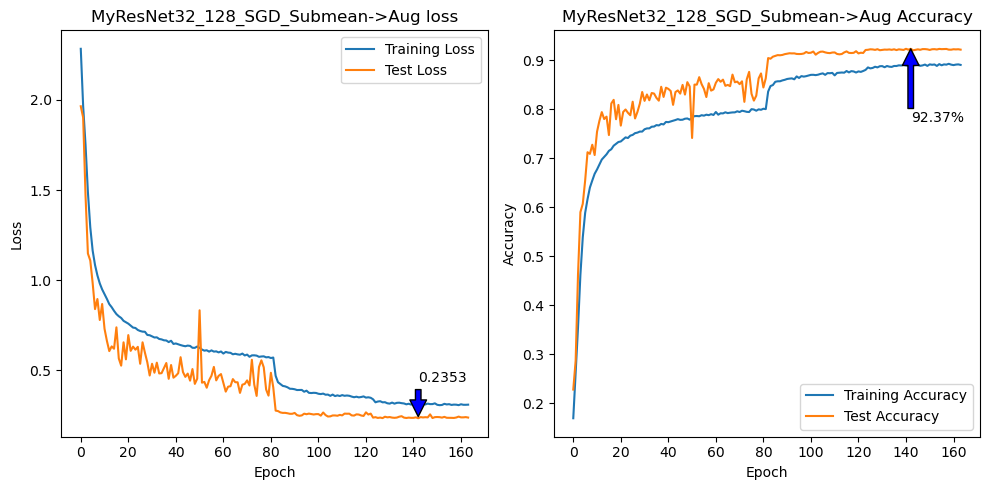

In [18]:
view = LogViewer(logs)
view.draw(title=file_name+"_Submean->Aug",min_marker=True, save=True)

In [ ]:
view.print_all()

1 epoch: train_loss=2.2826, train_acc=0.1693, test_loss=1.9642, test_acc=0.2279, lr=0.1000
2 epoch: train_loss=1.9653, train_acc=0.2625, test_loss=1.9019, test_acc=0.2867, lr=0.1000
3 epoch: train_loss=1.7514, train_acc=0.3551, test_loss=1.4698, test_acc=0.4636, lr=0.1000
4 epoch: train_loss=1.4882, train_acc=0.4621, test_loss=1.1483, test_acc=0.5901, lr=0.1000
5 epoch: train_loss=1.2936, train_acc=0.5389, test_loss=1.1093, test_acc=0.6072, lr=0.1000
6 epoch: train_loss=1.1643, train_acc=0.5887, test_loss=0.9847, test_acc=0.6548, lr=0.1000
7 epoch: train_loss=1.0845, train_acc=0.6166, test_loss=0.8402, test_acc=0.7125, lr=0.1000
8 epoch: train_loss=1.0271, train_acc=0.6404, test_loss=0.8961, test_acc=0.7092, lr=0.1000
9 epoch: train_loss=0.9825, train_acc=0.6548, test_loss=0.7799, test_acc=0.7278, lr=0.1000
10 epoch: train_loss=0.9492, train_acc=0.6685, test_loss=0.8685, test_acc=0.7068, lr=0.1000
11 epoch: train_loss=0.9233, train_acc=0.6773, test_loss=0.7309, test_acc=0.7545, lr=0.10